# Auto-Ticket Categorization using Machine Learning

### This project automatically classifies IT support tickets into categories like "VPN Issue", "Email Problem", or "Password Reset", using natural language processing (NLP) and machine learning.

### It also explains **which words influenced the model’s decision**, using logistic regression coefficients.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import nltk
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

We import necessary packages for text cleaning, vectorization, classification, and frontend.

## 2. Download Stopwords & Load spaCy

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import en_core_web_sm
nlp = en_core_web_sm.load(disable=["parser", "ner"])
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We use `nltk` to remove common stopwords and load `spaCy` for optional lemmatization (disabled in this pipeline).

## 3. Load Dataset

In [ ]:
df = pd.read_csv(r"C:\Users\fahee\Downloads\Project 2 - 2025\data\all_tickets_processed_improved_v3.csv")

print("✅ Dataset shape:", df.shape)
print("🧾 Available columns:", df.columns.tolist())
if 'Document' in df.columns and 'Topic_group' in df.columns:
    df = df[['Document', 'Topic_group']].dropna()
    df.rename(columns={'Document': 'cleaned_text', 'Topic_group': 'category'}, inplace=True)
    print("✅ Cleaned dataset shape:", df.shape)
    display(df.head())
else:
    raise ValueError("Expected columns 'Document' and 'Topic_group' not found in the dataset.")

✅ Dataset shape: (47837, 2)
🧾 Available columns: ['Document', 'Topic_group']
✅ Cleaned dataset shape: (47837, 2)


,cleaned_text,category
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


We load the dataset containing preprocessed support ticket text and their mapped categories.

## 4. Define Text Cleaning Function

In [ ]:
import re
import string
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    text = " ".join(text.split())  
    tokens = [token.lemma_ for token in nlp(text) if token.text not in STOPWORDS and not token.is_space]
    return " ".join(tokens)
df['cleaned_text'] = df['cleaned_text'].astype(str).apply(clean_text)
print("✅ Text cleaning done!")
df['cleaned_text'].head()

✅ Text cleaning done!


0    connection icon icon dear please setup icon pe...
1    work experience user work experience user hi w...
2    request meeting request meeting hi please help...
3    reset password external account expire day hi ...
4    mail verification warning hi get attach please...
Name: cleaned_text, dtype: object

This function lowercases the text, removes punctuation and numbers, and filters out stopwords.

## 5. Encode Target Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=50000)
X = vectorizer.fit_transform(df['cleaned_text'])

print(f"✅ Vectorized shape: {X.shape}")
print(f"✅ Classes: {label_encoder.classes_}")


✅ Vectorized shape: (47837, 50000)
✅ Classes: ['Access' 'Administrative rights' 'HR Support' 'Hardware'
 'Internal Project' 'Miscellaneous' 'Purchase' 'Storage']


We encode the `Topic_group` column into numerical labels for classification.

## 6. TF-IDF Vectorization

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Split complete")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

✅ Split complete
Train size: (38269, 50000)
Test size: (9568, 50000)


Convert cleaned text into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF).

## 7. Train Logistic Regression Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

nb = MultinomialNB()
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
svm = LinearSVC(class_weight='balanced')

nb.fit(X_train, y_train)
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)

print("✅ All models trained.")

✅ All models trained.


We train a `LogisticRegression` classifier using a One-vs-Rest strategy to support multi-class predictions.

## 8. Predict + Explain

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(name, model):
    print(f"📊 {name} Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}")
    print(classification_report(y_test, model.predict(X_test), target_names=label_encoder.classes_))

evaluate_model("Naive Bayes", nb)
evaluate_model("Logistic Regression", lr)
evaluate_model("Linear SVM", svm)

📊 Naive Bayes Accuracy: 0.7560
                       precision    recall  f1-score   support

               Access       0.93      0.73      0.82      1425
Administrative rights       0.99      0.19      0.32       352
           HR Support       0.77      0.81      0.79      2183
             Hardware       0.63      0.95      0.75      2724
     Internal Project       0.99      0.42      0.59       424
        Miscellaneous       0.83      0.63      0.72      1412
             Purchase       0.98      0.81      0.89       493
              Storage       0.99      0.54      0.70       555

             accuracy                           0.76      9568
            macro avg       0.89      0.64      0.70      9568
         weighted avg       0.80      0.76      0.75      9568

📊 Logistic Regression Accuracy: 0.8535
                       precision    recall  f1-score   support

               Access       0.90      0.87      0.88      1425
Administrative rights       0.69      0.83  

We build a prediction function that:
- Cleans the input ticket
- Predicts the category
- Multiplies model coefficients by TF-IDF features
- Returns top contributing words

This avoids SHAP and uses pure model logic.

<Figure size 1000x800 with 0 Axes>

c:\Users\fahee\Downloads\Project 2 - 2025\auto-tickets-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


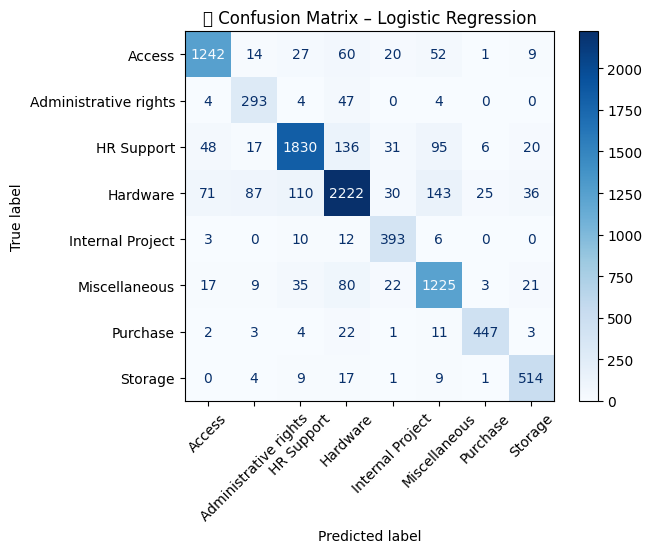

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("📊 Confusion Matrix – Logistic Regression")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_params = {
    "C": [0.1, 1, 2, 5],
    "penalty": ['l2'],
    "solver": ['liblinear'],  
}

lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000),
                       lr_params, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)

lr_grid.fit(X_train, y_train)

print("✅ Best LR Params:", lr_grid.best_params_)
print("🎯 Best LR F1 Score:", lr_grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best LR Params: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}
🎯 Best LR F1 Score: 0.8533112377019089


## 9. Launch Gradio Interface

In [ ]:
import gradio as gr
import numpy as np
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


In [ ]:
def predict_ticket_category(text):
    try:
        cleaned = clean_text(text)
        vec = vectorizer.transform([cleaned]).toarray()
        pred = lr.predict(vec)[0]
        label = label_encoder.inverse_transform([pred])[0]

        coefs = lr.coef_[pred]  
        contributions = vec.ravel() * coefs

        top_indices = np.argsort(np.abs(contributions))[::-1][:5]
        top_tokens = vectorizer.get_feature_names_out()[top_indices]
        top_scores = contributions[top_indices]

        explanation_lines = []
        for token, score in zip(top_tokens, top_scores):
            if score == 0:
                continue
            arrow = "↑" if score > 0 else "↓"
            explanation_lines.append(f"{arrow} {token:20} | Contribution = {score:+.6f}")

        if not explanation_lines:
            explanation = "⚠️ No meaningful words found (all contributions were 0.0)"
        else:
            explanation = "\n".join(explanation_lines)

        return label, explanation

    except Exception as e:
        return "⚠️ Prediction Failed", f"Error: {str(e)}"

Use `gr.Interface` to allow users to:
- Enter a support ticket
- See predicted category
- View top 5 contributing words from the model

In [73]:
gr.Interface(
    fn=predict_ticket_category,
    inputs=gr.Textbox(lines=4, placeholder="Paste a support ticket here..."),
    outputs=[
        gr.Label(label="Predicted Category"),
        gr.Textbox(label="Top Contributing Words (via LR coefficients)")
    ],
    title="🎫 Ticket Auto-Categorization",
    description="Enter a support ticket. Get category + top words influencing the model (via coefficients).",
    theme="default"
).launch()


* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset2.csv


## 10. Conclusion

This auto-ticket classifier uses a clean ML pipeline:
- TF-IDF + Logistic Regression
- Coefficient-based interpretability
- Simple and fast Gradio deployment

No SHAP needed, real-time explanations are lean, readable, and accurate.